In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.patches import Polygon
from matplotlib.colorbar import ColorbarBase
import seaborn as sns 
%matplotlib inline

# Is this bad practice in this case?
# Change to import *? Go through namespace?
from GDELT_utils import columns, usecols, dtype_dict, \
                        cameo_dict, map_cameo_to_text, \
                        state_dict, mem_usage, state_heat_map

# Introduction

In this report we're going to take a look at a small sample of the data from the Global Data on Events, Location and Tone project, also known as GDELT. GDELT provides data on global events, storing such things as the type of the event, the actors involved, the location and the tone of news reporting on the event. It thus provides an abstract and data driven view of the world's affairs. It has been in operation since 2013, and has data available from January 1, 1979 to the present. 

For our sample of the GDELT data, we're going to take a look at the data avaiable for the USA's presidential election days in 2008 and 2016: November 4th, 2008 and November 8th, 2016. Our goal is to survey the data and gain the preliminary understanding before a deeper dive. 

We first load in row limited samples of our two datasets. Our first step is to understand the data types present and to optimize our dataframe size and speed.

In [3]:
data_2008 = "D:/GDELT.MASTERREDUCEDV2.1979-2013/200811.CSV"
data_2016 = "D:/GDELT.MASTERREDUCEDV2.1979-2013/20161108.export.CSV"

df_2008_l = pd.read_csv(data_2008, sep='\t', nrows=1000)
df_2016_l = pd.read_csv(data_2016, sep='\t', nrows=1000)

df_2016_l.head()

,596760615,20151109,201511,2015,2015.8466,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,967537,3.1,"Times Square, New York, United States.1",US.1,USNY.1,40.757.1,-73.986.1,967537.1,20161108,http://www.wsaw.com/content/news/Candidates-make-final-stops-on-Election-Day-eve-400321591.html
0,596760616,20151109,201511,2015,2015.8466,NaN,NaN,NaN,NaN,NaN,...,1662328,3,"Los Angeles, California, United States",US,USCA,34.0522,-118.2440,1662328,20161108,http://www.rollingstone.com/culture/news/jinx-...
1,596760617,20151109,201511,2015,2015.8466,AUT,AUSTRIAN,AUT,NaN,NaN,...,AU,1,Austria,AU,AU,47.3333,13.3333,AU,20161108,https://www.scmagazine.com/swiss-investigators...
2,596760618,20151109,201511,2015,2015.8466,AUT,AUSTRIAN,AUT,NaN,NaN,...,IR,1,Austria,AU,AU,47.3333,13.3333,AU,20161108,https://www.scmagazine.com/swiss-investigators...
3,596760619,20151109,201511,2015,2015.8466,AUTJUD,AUSTRIAN,AUT,NaN,NaN,...,AU,1,Austria,AU,AU,47.3333,13.3333,AU,20161108,https://www.scmagazine.com/swiss-investigators...
4,596760620,20151109,201511,2015,2015.8466,BWAELIGOV,FESTUS MOGAE,BWA,NaN,NaN,...,-1397372,4,"Gaborone, South East, Botswana",BC,BC09,-24.6464,25.9119,-1397372,20161108,http://www.albuquerqueexpress.com/index.php/si...


We already have a problem! The CSV's do not provide a header. With the documentation, we can determine that there are 58 columns for data after April 2013, and 57 before. With this, we can reload our dataframes properly.

In [4]:
df_2008_l = pd.read_csv(data_2008, sep='\t', names=columns[:57], nrows=1000)
df_2016_l = pd.read_csv(data_2016, sep='\t', names=columns, nrows=1000)

And now we can take a closer look at the data with the info method.

In [5]:
df_2008_l.info(memory_usage='deep')
df_2016_l.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 57 columns):
GLOBALEVENTID            1000 non-null int64
SQLDATE                  1000 non-null int64
MonthYear                1000 non-null int64
Year                     1000 non-null int64
FractionDate             1000 non-null float64
Actor1Code               0 non-null float64
Actor1Name               0 non-null float64
Actor1CountryCode        0 non-null float64
Actor1KnownGroupCode     0 non-null float64
Actor1EthnicCode         0 non-null float64
Actor1Religion1Code      0 non-null float64
Actor1Religion2Code      0 non-null float64
Actor1Type1Code          0 non-null float64
Actor1Type2Code          0 non-null float64
Actor1Type3Code          0 non-null float64
Actor2Code               1000 non-null object
Actor2Name               1000 non-null object
Actor2CountryCode        535 non-null object
Actor2KnownGroupCode     12 non-null object
Actor2EthnicCode         0 non-null float64
Ac

By default, Pandas makes safe but space inefficient choices for value data types by always defaulting to int64/float64/object. We can reduce memory use and load performance when making a dataframe out of the full CSV's by omitting any extra data that we are not interested in for our current analysis and, more importantly, by determining optimized data types for each column.

For the latter case, we note by looking at the [Data Format Codebook](http://data.gdeltproject.org/documentation/GDELT-Data_Format_Codebook.pdf) that there are multiple columns which encode dates in different ways. There are also DATEADDED and SOURCEURL fields, describing the date the record was added to the data set and the source of the news respectively, which will not have any bearing on our analysis. Thus we omit those columns. 

Next we look into appropriate data types for our columns. For this analysis we follow the lead of [Using pandas with large data](https://www.dataquest.io/blog/pandas-big-data/). We first filter our dataframes for particular classes of types: integers/floats/objects. For the purposes of this report, we only follow the work on a single dataframe but the analysis has been applied to both.

In [6]:
df_2008_l_int = df_2008_l.select_dtypes(include=['int64'])
df_2008_l_int.columns

Index(['GLOBALEVENTID', 'SQLDATE', 'MonthYear', 'Year', 'IsRootEvent',
       'EventCode', 'EventBaseCode', 'EventRootCode', 'QuadClass',
       'NumMentions', 'NumSources', 'NumArticles', 'Actor1Geo_Lat',
       'Actor1Geo_Long', 'Actor1Geo_FeatureID', 'Actor2Geo_Type',
       'Actor2Geo_FeatureID', 'DATEADDED'],
      dtype='object')

We can then attempt to apply "downcasting" to these integer columns. That is, we can use a method of Pandas, to_numeric, to find the smallest size integer type which will support all values of the columns. The available types are int8, int16, int32 and int64, as well as unsigned variants (only positive numbers) uint8, uint16, uint32 and uint64. The numbers at the end of each type indicate the number of bits consumed in order to represent the data type, and thus smaller numbers correspond with smaller memory consumption. 

We also note that through inspection of the data documentation that all of these columns will have positive values. (We also find that some of these fields are not best represented as integers for the purposes of analysis, more on this below.) We now apply the downcasting into unsigned integer data types and show a comparison of memory usage.

In [7]:
converted_int = df_2008_l_int.apply(pd.to_numeric,downcast='unsigned')

num_before, str_before = mem_usage(df_2008_l_int)
num_after, str_after = mem_usage(converted_int)

print("Before downcast: ", str_before)
print("After downcast: ", str_after)
print("Percent Decrease", 1 - num_after / num_before)

Before downcast:  0.14 MB
After downcast:  0.04 MB
Percent Decrease 0.7287617990005553


We thus see a fairly remarkable 72% decrease of memory usage in this simple example. A similar process applies to float columns. The more involved data optimization involves the object columns, which includes string values. In some cases, there is nothing we can do. This generally applies when there are many unique string values in a column. However, if there are sufficient repeats, we can use a different numpy data type known as a category. 

This data type leverages a map-like structure to translate repeated strings into less memory intensive integers, and then covertly replaces the repeated values with these integers. The original values are then recoverable in this case by following the mapping. This can result in huge increases in memory efficiency. For a first pass, we apply a methodology present in our source for this memory optimization which replaces an object column with category if less than 50% of the values are unique.

In [8]:
df_2008_l_obj = df_2008_l.select_dtypes(include=['object'])
df_2008_l_obj.columns

Index(['Actor2Code', 'Actor2Name', 'Actor2CountryCode', 'Actor2KnownGroupCode',
       'Actor2Religion1Code', 'Actor2Religion2Code', 'Actor2Type1Code',
       'Actor2Type2Code', 'Actor2Type3Code', 'Actor2Geo_FullName',
       'Actor2Geo_CountryCode', 'Actor2Geo_ADM1Code', 'ActionGeo_FullName',
       'ActionGeo_CountryCode', 'ActionGeo_ADM1Code'],
      dtype='object')

In [9]:
converted_obj = pd.DataFrame()

for col in df_2008_l_obj.columns:
    num_unique_values = len(df_2008_l_obj[col].unique())
    num_total_values = len(df_2008_l_obj[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = df_2008_l_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = df_2008_l_obj[col]
        
num_before, str_before = mem_usage(df_2008_l_obj)
num_after, str_after = mem_usage(converted_obj)

print("Before downcast: ", str_before)
print("After downcast: ", str_after)
print("Percent Decrease", 1 - num_after / num_before)

Before downcast:  0.74 MB
After downcast:  0.24 MB
Percent Decrease 0.675466344710465


We now collate the information revealed by these naive data type passes as well as our knowledge of the documentation to arrive at our final data types for the columns we wish to investigate.

In [10]:
dtype_dict

{'GLOBALEVENTID': 'uint32',
 'Actor1Code': 'category',
 'Actor1Name': 'str',
 'Actor1CountryCode': 'category',
 'Actor1KnownGroupCode': 'category',
 'Actor1EthnicCode': 'category',
 'Actor1Religion1Code': 'category',
 'Actor1Religion2Code': 'category',
 'Actor1Type1Code': 'category',
 'Actor1Type2Code': 'category',
 'Actor1Type3Code': 'category',
 'Actor2Code': 'category',
 'Actor2Name': 'str',
 'Actor2CountryCode': 'category',
 'Actor2KnownGroupCode': 'category',
 'Actor2EthnicCode': 'category',
 'Actor2Religion1Code': 'category',
 'Actor2Religion2Code': 'category',
 'Actor2Type1Code': 'category',
 'Actor2Type2Code': 'category',
 'Actor2Type3Code': 'category',
 'IsRootEvent': 'bool_',
 'EventCode': 'str',
 'EventBaseCode': 'str',
 'EventRootCode': 'str',
 'QuadClass': 'uint8',
 'GoldsteinScale': 'float32',
 'AvgTone': 'float32',
 'NumMentions': 'uint16',
 'NumSources': 'uint16',
 'NumArticles': 'uint16',
 'Actor1Geo_Type': 'float16',
 'Actor1Geo_FullName': 'str',
 'Actor1Geo_CountryCo

In [11]:
df_2008_l_opti = pd.read_csv(data_2008, sep='\t', names=columns[:57], \
                        usecols=usecols, dtype=dtype_dict, \
                        parse_dates=['SQLDATE'], nrows=1000)
df_2016_l_opti = pd.read_csv(data_2016, sep='\t', names=columns, \
                        usecols=usecols, dtype=dtype_dict, \
                        parse_dates=['SQLDATE'], nrows=1000)

num_before, str_before = mem_usage(df_2008_l)
num_after, str_after = mem_usage(df_2008_l_opti)

print("Before downcast: ", str_before)
print("After downcast: ", str_after)
print("Percent Decrease", 1 - num_after / num_before)

Before downcast:  1.06 MB
After downcast:  0.68 MB
Percent Decrease 0.36238106842168205


In the end, with optimized data type choices that also take into consideration the type of analysis we wish to perform, we have a 36% reduction in memory usage for our limited samples. And note we can expect the memory savings to be even greater for the full data frames assuming we chose our category columns correctly!

# Data Exploration

In [12]:
df_2008 = pd.read_csv(data_2008, sep='\t', names=columns[:57], \
                        usecols=usecols, dtype=dtype_dict, \
                        parse_dates=['SQLDATE'])
df_2016 = pd.read_csv(data_2016, sep='\t', names=columns, \
                        usecols=usecols, dtype=dtype_dict, \
                        parse_dates=['SQLDATE'])

In [13]:
print(mem_usage(df_2008)[1])
print(mem_usage(df_2016)[1])

730.73 MB
142.42 MB


We know that we want to filter rows in these two dataframes to include only events about the United States as well as for the news on the correct election date. In the former case, we'll use the column "ActionGeo_CountryCode" to determine where the action is reported as having taken place. 

In [14]:
df_2008['ActionGeo_CountryCode'].unique()

[AF, US, CA, ID, UK, ..., FK, NT, AV, NF, VC]
Length: 241
Categories (240, object): [AF, US, CA, ID, ..., NT, AV, NF, VC]

In [15]:
df_2008_us = df_2008[df_2008['ActionGeo_CountryCode'] == 'US']
df_2016_us = df_2016[df_2016['ActionGeo_CountryCode'] == 'US']

As for the dates, we'll first look at what data is present in our SQLDATE columns for each dataframe.

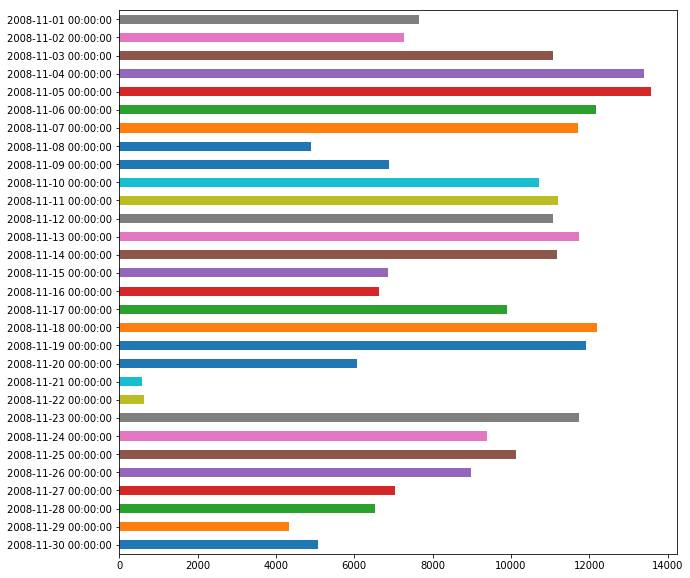

In [34]:
df_2008_us['SQLDATE'].value_counts() \
                     .sort_index(ascending=False) \
                     .plot.barh(figsize=(10,10));

Thus we see a significant uptick in news on and around election day which matches what we would expect. We also do not see any unexpected dates in this 2008 dataframe. Now we look at the 2016 dataframe. The 2016 dataframe was loaded from a CSV labeled for the exact day we are interested in, November 8th, 2016, so this is really just a sanity check on the data.

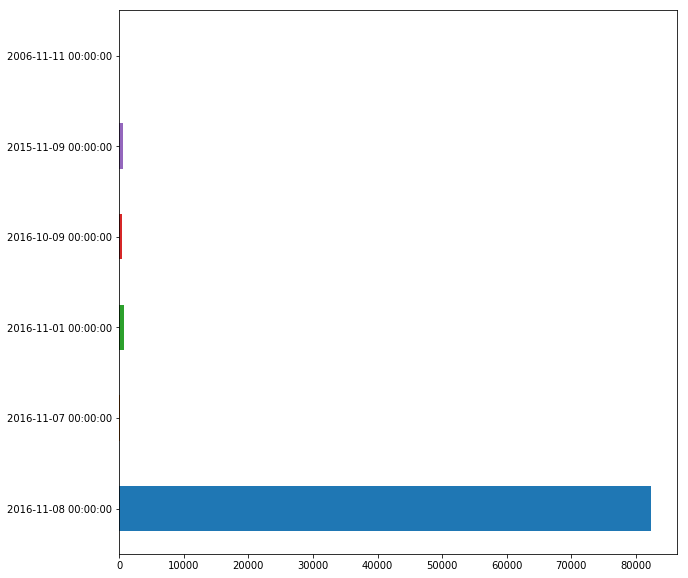

In [36]:
df_2016_us['SQLDATE'].value_counts() \
                     .sort_index(ascending=False) \
                     .plot.barh(figsize=(10,10));

And it's a good thing we did it! There are other dates floating around in the dataset which appear to be anomalous. There's at least one 2006 date where appears to be a typo, as well as a 2015 date thrown in this dataset. This indicates we should be sure to filter our 2016 dataset for date as well. 

In [37]:
election_day_2008 = np.datetime64('2008-11-04')
df_2008_usel = df_2008_us[df_2008_us['SQLDATE'] == election_day_2008]
election_day_2016 = np.datetime64('2016-11-08')
df_2016_usel = df_2016_us[df_2016_us['SQLDATE'] == election_day_2016]

With our data prepared, we can now start looking at the column of interest we set out to explore, AvgTone. First, let's get an idea of the range of values for our dataframes.

Text(0.5,1,'Average Tone on Election Day 2016')

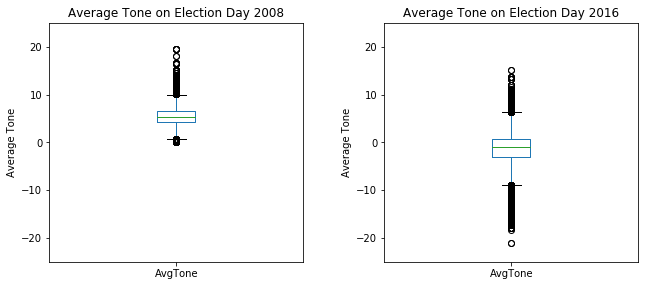

In [46]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.tight_layout(pad=5)

plt.subplot(1,2,1)
df_2008_usel['AvgTone'].plot(kind='box');
plt.ylim(-25, 25)
plt.ylabel("Average Tone")
plt.title("Average Tone on Election Day 2008")

plt.subplot(1,2,2)
df_2016_usel['AvgTone'].plot(kind='box');
plt.ylim(-25, 25)
plt.ylabel("Average Tone")
plt.title("Average Tone on Election Day 2016")

We notice right away that the tone of news stories coming out in 2008 was substantially higher and with far fewer variance than what was being seen in 2016. We can break this down further and attempt to understand the tone of news stories reporting on actions in particular states.  To do this, we'll first have to dig a little deeper into the data and look at the ActionGeo_ADM1Code column which codes more specified location information.

In [47]:
df_2008_usel['ActionGeo_ADM1Code'].unique()

[USDC, USMD, US, USMO, USOR, ..., USRI, USDE, USWI, USAR, USWY]
Length: 53
Categories (53, object): [USDC, USMD, US, USMO, ..., USDE, USWI, USAR, USWY]

We see that the codes for US states are provided in the format of US followed by the 2 letter state code, provided that the data was able to be localized down to the state level. State dict has already been defined in our GDELT_utils.py to map the codes to the state name. We use it to rename our indices and present the data as grouped by state.

In [48]:
avgtone_2008 = df_2008_usel.groupby('ActionGeo_ADM1Code')['AvgTone'] \
            .mean()[np.sort(df_2008_usel['ActionGeo_ADM1Code'].unique())] \
            .rename(state_dict)
avgtone_2016 = df_2016_usel.groupby('ActionGeo_ADM1Code')['AvgTone'] \
            .mean()[np.sort(df_2016_usel['ActionGeo_ADM1Code'].unique())] \
            .rename(state_dict)
        
print(avgtone_2008, avgtone_2008.min(), avgtone_2008.max())
print(avgtone_2016, avgtone_2016.min(), avgtone_2016.max())

ActionGeo_ADM1Code
National                5.820637
Alaska                  5.319072
Alabama                 5.109504
Arkansas                4.533150
Arizona                 5.315331
California              5.400719
Colorado                5.505959
Connecticut             5.460418
District of Columbia    5.663906
Delaware                5.338939
Florida                 4.958261
Georgia                 5.191751
Hawaii                  6.233624
Iowa                    7.070680
Idaho                   5.134227
Illinois                5.449138
Indiana                 5.701856
Kansas                  6.079074
Kentucky                5.428138
Louisiana               6.025946
Massachusetts           6.210039
Maryland                5.618937
Maine                   5.606378
Michigan                5.917829
Minnesota               5.447912
Missouri                5.119651
Mississippi             5.182970
Montana                 5.741175
North Carolina          5.174797
North Dakota            

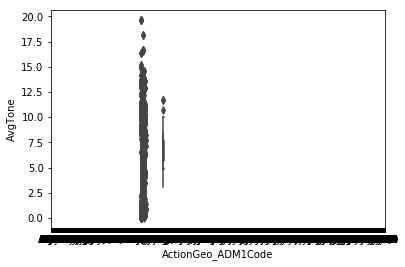

In [51]:
sns.boxplot(data=df_2008_usel, x='ActionGeo_ADM1Code', y='AvgTone')
plt.show()

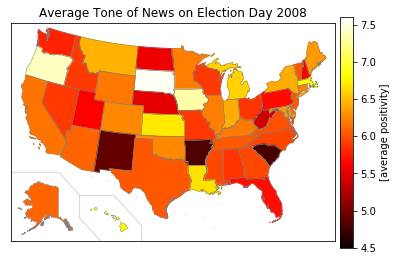

In [53]:
state_heat_map(avgtone_2008, 4.5, 7.6, 'Average Tone of News on Election Day 2008')

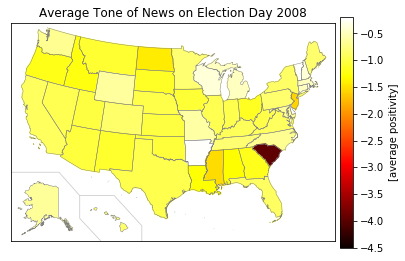

In [55]:
state_heat_map(avgtone_2016, -4.5, -0.2, 'Average Tone of News on Election Day 2008')

# References and Data Sources

https://github.com/matplotlib/basemap/blob/master/examples/fillstates.py
    
https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
    
https://www.dataquest.io/blog/pandas-big-data/ 
    
http://data.gdeltproject.org/documentation/GDELT-Data_Format_Codebook.pdf
    
https://www.gdeltproject.org/data.html
    http://data.gdeltproject.org/events/200811.zip
    http://data.gdeltproject.org/events/20161108.export.CSV.zip